
**Exercise 1.**


Pre-processing of the data:

* Importing all the necessary packages for the project, including the nltk package, which is specific for text mining functions.

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import nltk as nl
from nltk.tokenize import word_tokenize
import pandas as pd

* Importing state of the union speech as our data for text mining. 

In [2]:
#Import state-of-the-union speech
text_raw = pd.read_csv('./speech_data_extend.txt', sep='\t')

* Each row in the dataframe corresponds to a paragraph (i.e. an address). We only take the speeches starting from 2000, and get exactly 1232 paragraphs. 

(*Taking a subset of all State of the Union addresses helps us speeding up the processing in exercises 3 and 4. However, the methods developed in exercises 2, 3 and 4 could be applied to the whole corpus of addresses without loss of generality. It would just require some extra processing time.*)

In [3]:
#Consider paragraphs after 2000.
text_data = text_raw.loc[text_raw['year']>=2000, :]

#Number of paragraphs:
print("Number of paragraphs (from year 2000): %d" %len(text_data))

Number of paragraphs (from year 2000): 1232


* Steps in Preprocessing of the data:
   
    + **Tokenization**: Tokenization is the splitting of a raw character string into individual elements of interest: words, numbers, punctuation. We strip out all non-alphabetic elements.
    
    + **Stopword removal**: Stopwords are connecting words with little semantic information that are typically removed from token lists because they do not help distinguish one document from another.
    
    + **Linguistic roots**: Most often, the relevant information in tokens is their linguistic root, not their grammatical form. We want to treat ‘prefer’, ‘prefers’, ‘preferences’ as equivalent tokens. We use the stemming option using Porter Stemmer. 

In [4]:
##1. Preprocessing of the data
from stop_words import get_stop_words
stop_words = get_stop_words('en')
from nltk.stem.porter import PorterStemmer
st = PorterStemmer()
docs = pd.Series(np.zeros(text_data.shape[0]))
tokens = [] #List of all words.

# Download corpora if necessary: nl.download()


for i, line in enumerate(text_data['speech']):
    #Tokenize the data:
    doc_i = word_tokenize(line.lower())
    #Remove non-alphabetic characters:
    doc_i = [tok for tok in doc_i if tok.isalpha()]
    #Remove stopwords using a list of your choice:
    doc_i = [tok for tok in doc_i if tok not in stop_words]
    #Stem the data using the Porter stemmer:
    doc_i = [st.stem(tok) for tok in doc_i]

    tokens.extend(doc_i)
    docs.iloc[i] = doc_i

* Calculation of the TF-IDF, removing of the less relevant words based on the TF-IDF and calculation of the document-term matrix.

-----------------

**TF-IDF** is a weighting of the terms in the document that allows to normalize the count/frequency of each term. It is composed of the following elements:

1-----------------

**TF (term frequency) score**: Frequency of a term in a document. More frequent a term, more chances that this particular document is relevant to this query term. 

Let x be the count of the $v_{th}$ term in document d. Then its tf score is given as:
tf = 1 + log(x).

2-----------------

**IDF (inverse document frequency) score**: It is computed by taking the logarithm of the total number of documents in the corpus divided by the number of documents where the term occurred. This normalization is to up-weight the rare terms in the corpus.

Let df be the number of documents that contain the term v, and D the total number of documents. Then its idf score is given as:
idf = log(D/df).

-----------------

Combining the two observations, the term frequency - inverse document frequency of term v in document d is calculated as: $tf-idf = tf \times idf$.

In [5]:
# Corpus-level tf-idf score for every term, and choose a cutoff below which to remove words.
unique_words = np.unique(tokens)
lw = len(unique_words) # Number of words
ld = len(docs) # Number of documents


word_count = nl.FreqDist(tokens)
tf = {k: 1+np.log(v) for k, v in word_count.items()}
df = {k: np.sum(list(map(lambda x: k in x, docs))) for k in word_count.keys()}
idf = {k: np.log(ld/v) for k, v in df.items()}
tfidf = {k : v * tf[k] for k, v in idf.items() if k in tf}


# Based on the ranking we select 500 words with highest tf-idf
# 1st we get the rank
import operator
rank = sorted(tfidf.items(), key=operator.itemgetter(1), reverse=True)
cutoff = rank[500][1]
# 2nd apply the cut-off
selected_words = {k: v for k, v in tfidf.items() if v>cutoff}
ls = len(selected_words) # number of selected words: 500

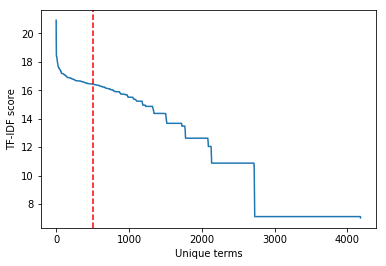


 Number of unique words: 4181

 Number of selected words (cutoff 16.4 tf-idf): 500


In [6]:
plt.plot([x[1] for x in rank])
plt.axvline(500, color='red',linestyle='dashed')
plt.xlabel("Unique terms")
plt.ylabel("TF-IDF score")
plt.show()
print("\n Number of unique words: %d" %lw)

print("\n Number of selected words (cutoff %3.1f tf-idf): %d" %(cutoff,ls))

#Document-term matrix using 500 words selected using the tf-idf score.
X = pd.DataFrame(np.zeros(shape = (ld, ls)), columns = selected_words.keys())

for w in selected_words.keys():
    X[w] = list(map(lambda x: x.count(w), docs))

In the choosing of the cutoff TF-IDF score, we have considered a lower value than that suggested by the chart (1500 or 2000) in order to speed up the calculations for exercises 3 and 4. With larger cutoff limits, the same code would apply but would require more time for the processing of the data.

The table below presents the top-20 terms with the highest TF-IDF score:

| Terms with the highest TF-IDF|
| :-----------------------:|
| gun, earmark, sun, agreement, teacher, trade, ga, border, iran, cori|
| deserv, aid, prison, iraqi, marriag, afghan, export, saddam, inspector|



**Exercise 2.**


We want to measure the heterogeneity across addresses based on positive and negative economic words. 

For this purpose, we use the Loughran-McDonald Master Dictionary (henceforth, LM dictionary) which uses words in 10-K documents to complement the general dictionary with economic terms.

The table below presents the list of negative and uncertainty terms (as identified in the LM dictionary) within the selected significant terms (i.e. 500 with the highest TF-IDF score, as found in exercise 1) appearing in the addresses from 2000 to 2014.

| Type         | Terms in our corpus |
|:-------------:|:-----------------------:|
| Negative | threaten, **crime**, destruct, destroy, **violenc**, wors, defeat, fail, bad, fear, wast, lost, <br> recess, deni, unemploy, seriou, critic, close, concern, lose, fire, break, <br> question, burden, defens, illeg, difficult|
| Uncertainty            |depend, risk, might, may |


We note that there are some words that clearly refer to crime rather than to economic difficulties. We therefore remove them from the dictionary because we are only interested in measuring economic turmoil. 

Using the document-term matrix (first without weighting by TF-IDF), we sum the occurrence of these terms in each address and divide them by the number of total occurrence of the terms in the corpus (i.e. all addresses from 2000 to 2014).

We then map each address to a year, and sum up the occurrences of the terms above corresponding to the same year. We plot the results together with data on the the economic situation in the United States during the same period. 

In particular, we take OECD data on GDP growth in the period 2000-2014. Since the State of the Union addresses take place in January or February of each year, we use the the % GDP growth at the end of the previous year as a proxy of the economic situation. 

For illustrative purposes, in the chart we inverse the GDP growth (i.e. change the sign) in order to make it match the word count. That is, since we are measuring the occurrence of negative terms, we expect high word counts to match recession periods, i.e. negative GDP growth.  

In [7]:
##2. Analysis using dictionary methods:
# Load the dictionary & select list of negative and uncertainty words
dictionary = pd.read_csv('./LoughranMcDonald_MasterDictionary_2014.csv')
neg_words = dictionary.loc[dictionary['Negative']!=0,'Word']
uncert_words = dictionary.loc[dictionary['Uncertainty']!=0,'Word']

# Stem words in dictionary
for i,line in enumerate(neg_words):
    neg_words.iloc[i] = st.stem(neg_words.iloc[i])

for i,line in enumerate(uncert_words):
    uncert_words.iloc[i] = st.stem(uncert_words.iloc[i])

negative = list(set(neg_words))
uncertain = list(set(uncert_words))

# List of negative/uncert words appearing among those selected using tf-idf
negative_subset = list(set(negative)&set(list(selected_words.keys())))
uncertain_subset = list(set(uncertain)&set(list(selected_words.keys())))
negative_uncertain = negative_subset + uncertain_subset

# We reduce the document-term matrix to these columns
DM = X[negative_uncertain]

# We drop those words that relate to crime
DM.drop(['crime','violenc'], axis=1, inplace=True)

# sum all columns (i.e. number of negative terms per paragraph) and divide by the number of negative terms in the whole corpus
DM_negative = DM.sum(axis=1)/DM.values.sum()

# Map paragraphs to years
nyears = np.unique(text_data['year']).size
year0 = np.unique(text_data['year'])[0]
years = np.zeros(nyears+1,dtype=np.int)

for i in range(nyears):
    if(i==0):
        years[i+1] = len(text_data.loc[text_data['year']==year0,:])
    else:
        years[i+1] = years[i] + len(text_data.loc[text_data['year']==(year0+i),:])

# we collapse by year (adding all negative terms made in one State-of-the-union)
negative_year = np.zeros(nyears)
for i in range(nyears):
    negative_year[i] = DM_negative[years[i]:years[i+1]].values.sum()


/Users/veldanie/cml-env/lib/python3.6/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


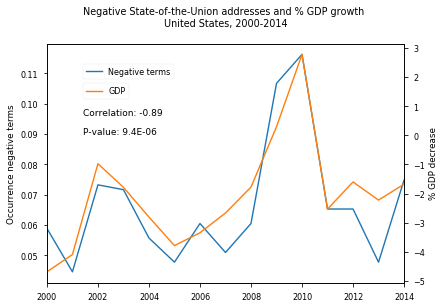

In [8]:
# load OECD data on GDP growth in the US 
gdp = pd.read_csv('./OECD_annual.csv')
chart_gdp = pd.DataFrame(index=np.unique(text_data['year']),data=np.asarray(-gdp['Value']))

# load the results
chart_data = pd.DataFrame(index=np.unique(text_data['year']),data=negative_year)

# join them
chart_info = pd.concat([chart_data,chart_gdp],axis=1)
chart_info.columns = ['Negative terms','GDP']

# calculate correlation
from scipy.stats.stats import pearsonr
stats = pearsonr(np.asarray(gdp['Value']),negative_year)


# plot
import matplotlib
matplotlib.style.use('seaborn-paper')
ax = chart_info.plot(secondary_y=['GDP'])
ax.legend(loc=(0.1,0.85))
ax.right_ax.legend(loc=(0.1,0.77))
ax.text(0.1, 0.7,'Correlation: {:4.2f}' .format(stats[0]),transform = ax.transAxes, fontsize=9)
ax.text(0.1, 0.62,'P-value: {:.1E}' .format(stats[1]),transform = ax.transAxes, fontsize=9)

ax.set_title('Negative State-of-the-Union addresses and % GDP growth \n United States, 2000-2014 \n')
ax.set_ylabel('Occurrence negative terms')
ax.right_ax.set_ylabel('% GDP decrease')
plt.show()


We note that the correlation between a State-of-the-Union address with a prevalence of negative economic words and a bad economic situation is high and significant. 

Moreover, it has the sign we expected: negative. Indeed, the higher the occurrence of negative words, the worse the economic situation. This is particularly the case during the 2008-2010 crisis. 

The chart below shows the results of applying the same procedure but using the TF-IDF weighting instead of the unweighted document-term matrix. 

We note that the results of applying the TF-IDF weighting are in line with those obtained with the unweighted document-term matrix: strong and significant negative correlation. However, we note that the correlation obtained with the TF-IDF weighting is slightly higher and slightly more significant (lower p-value). 

/Users/veldanie/cml-env/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


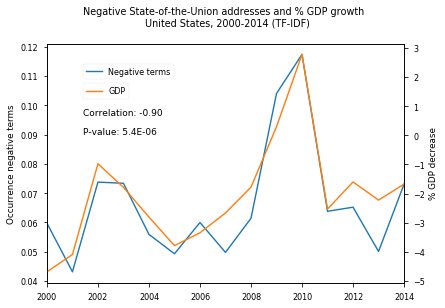

In [9]:
# Generate the tf-idf-weighted document-term matrix S.
tf = X.copy()
tf[tf > 0] = 1+ np.log(X[X>0]) #term frequency for each word and each document.

S = X.copy()
for i in range(ls):
    S[tf.columns[i]] = tf.iloc[:,i] * idf[tf.columns[i]] #tf*inverse document frequency


# We reduce the document-term matrix to these columns
DM2 = S[negative_uncertain]

# We drop those words that relate to crime
DM2.drop(['crime','violenc'], axis=1, inplace=True)

# sum all columns (i.e. number of negative terms per paragraph) and divide by the number of negative terms in the whole corpus
DM2_negative = DM2.sum(axis=1)/DM2.values.sum()

# we collapse by year (adding all negative terms made in one State-of-the-union)
negative_year2 = np.zeros(nyears)
for i in range(nyears):
    negative_year2[i] = DM2_negative[years[i]:years[i+1]].values.sum()

# load the results
chart_data2 = pd.DataFrame(index=np.unique(text_data['year']),data=negative_year2)

# join them
chart_info2 = pd.concat([chart_data2,chart_gdp],axis=1)
chart_info2.columns = ['Negative terms','GDP']

# calculate correlation
from scipy.stats.stats import pearsonr
stats = pearsonr(np.asarray(gdp['Value']),negative_year2)


# plot
ax = chart_info2.plot(secondary_y=['GDP'])
ax.legend(loc=(0.1,0.85))
ax.right_ax.legend(loc=(0.1,0.77))
ax.text(0.1, 0.7,'Correlation: {:4.2f}' .format(stats[0]),transform = ax.transAxes, fontsize=9)
ax.text(0.1, 0.62,'P-value: {:.1E}' .format(stats[1]),transform = ax.transAxes, fontsize=9)

ax.set_title('Negative State-of-the-Union addresses and % GDP growth \n United States, 2000-2014 (TF-IDF)\n')
ax.set_ylabel('Occurrence negative terms')
ax.right_ax.set_ylabel('% GDP decrease')
plt.show()




**Exercise 3.**


The data processing performed in exercise 1 allowed us to generate the document-term matrix $X$ by counting the number times that each term occurs in each document. In our analysis, a document corresponds to a paragraph of the corpus, and we considered the period from 2000 to 2014. Within this period we observed 1232 paragraphs. After computing the corpus-level tf-idf score for every term, we selected 500 words. Therefore $X$ is a $1232\times 500$ matrix. 

The following script calculates the tf-idf-weighted document-term matrix $S$. This matrix is built based on the document-term matrix $X$. We perform the singular value decomposition on $S$, and retain 200 sigular values, i.e. $\Sigma_{ii}=0$ for $i>200$. Then we estimate $\hat{S}= A\Sigma B$. 




In [10]:
##3. Generate the tf-idf-weighted document-term matrix S. Perform SVD.

tf = X.copy()
tf[tf > 0] = 1+ np.log(X[X>0]) #term frequency for each word and each document.

S = X.copy()
for i in range(ls):
    S[tf.columns[i]] = tf.iloc[:,i] * idf[tf.columns[i]] #tf*inverse document frequency

# Singular Value Decomposition:
S_svd = np.linalg.svd(S, full_matrices=1, compute_uv=1)
#X = A SIGMA B
A = S_svd[0]
SIGMA = np.vstack((np.diag(S_svd[1]),np.zeros(shape = (ld-ls, ls))))
B = S_svd[2]

#We retain 200 singular values and approximate S.
SIGMA2 = SIGMA.copy()
for i in range(200,ls-1):
    SIGMA2[i,i] = 0

S_hat = A.dot(SIGMA2).dot(B)


Next, we compare the cosine similarity of documents using both $S$ and $\hat{S}$. As mentioned before, the period under analysis comprises 2000-2014. Within this period we have 560 documents from Obama speeches, and 544 documents from Bush speeches. For the exercise, we compute the average cosine similarity within and across speeches made by Obama and Bush. Thefore we estimata 3 averages using $S$ and another 3 averages using $\hat{S}$. The figure below exhibits the results.

![Cosine Similarity](cs.png)

As expected, the average cosine similarity within Bush and within Obama, is higher than the average cosine similary when crossing documents from Bush and Obama. This result is consistent for both $S$ and $\hat{S}$. Additionally, we observe that the similarities estimated using $\hat{S}$ are higher than those estimated with $S$. The following script shows a function that calculates the similarity and the procedure to estimate the averages.  


In [11]:
# Function that estimates Cosine similarity:
def cos_sim (di, dj):
    if np.sum(di)==0 or np.sum(dj)==0:
        sim = 0
    else:
        sim = np.dot(di,dj)/(np.sqrt(np.dot(di,di))*np.sqrt(np.dot(dj,dj)))
    return (sim)

#Cosine similarites using S and S_hat:
S_B = np.array(S)[text_data['president']=='BushII']
S_O = np.array(S)[text_data['president']=='Obama']

S_hat_B = S_hat[text_data['president']=='BushII']
S_hat_O = S_hat[text_data['president']=='Obama']

#Bush within Average Cosine Similarity:
bb1 = np.mean([cos_sim(S_B[i],S_B[j]) for i in range(S_B.shape[0]) for j in range(S_B.shape[0])])
bb2 = np.mean([cos_sim(S_hat_B[i],S_hat_B[j]) for i in range(S_hat_B.shape[0]) for j in range(S_hat_B.shape[0])])

#Obama within Average Cosine Similarity:
oo1 = np.mean([cos_sim(S_O[i],S_O[j]) for i in range(S_O.shape[0]) for j in range(S_O.shape[0])])
oo2 = np.mean([cos_sim(S_hat_O[i],S_hat_O[j]) for i in range(S_hat_O.shape[0]) for j in range(S_hat_O.shape[0])])

#Bush-Obama cross Average Cosine Similarity:
bo1 = np.mean([cos_sim(S_B[i],S_O[j]) for i in range(S_B.shape[0]) for j in range(S_O.shape[0])])
bo2 = np.mean([cos_sim(S_hat_B[i],S_hat_O[j]) for i in range(S_hat_B.shape[0]) for j in range(S_hat_O.shape[0])])

ind = np.arange(3)  # the x locations for the groups
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(ind, (bb1, oo1, bo1), width, color='r')
rects2 = ax.bar(ind + width, (bb2, oo2, bo2), width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('Average Cosine Similarity')
ax.set_title('Average Cosine Similarity \n within and across Bush and Obama (2000, 2014)')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Bush-Bush', 'Obama-Obama', 'Bush-Obama'))
ax.legend((rects1[0], rects2[0]), ('S', 'S_hat'))
#plt.show()
fig.savefig('cs.png')



**Exercise 4.**


Given the document-term matrix $X$ generated in exercise 1 by counting the number times that each term occurs in each document, we estimate a multinomial mixture model using the EM algorithm. We assume there exists two topics, i.e. $K=2$. We initialize the probability of each topic $\rho_{k}=1/2$, for $k=1,2$. For each topic, the vector of term probabilities $\beta_{k}$ is initialized by drawing a sample from a Dirichlet distribution. Given that during the data-processing stage at exercise 1 we selected 500 words, in our application $\beta_{k}$ has length 500. 

The EM algorithm allows us to update the estimate of $\rho_{k}$ and $\beta_{k}$ for $k=1,2$. At each iteration we calculate the log-likelihood and verify that it increases. If the increment is less than 1, we stop the procedure. The next figure shows the log-likelihood as a function of the number of iterations.

![Log-Likelihood function. Multinomial Mixture Model.](ll.png)



The table below exhibits some of the terms with highest probability after estimating $\beta_{k}$, for $k=1,2$ using the EM algorithm.

| Topic         | Terms with highest probability|
| ------------- |:-----------------------:|
| 1             | border, nuclear, east, Iran, Iraq, troop, Afghanistan, regim, oil|
| 2             | social, rate, vote, benefit, medicar, parent, coverag, retir, industri|


Given the results, we assign the label **Geopolitics** to topic 1, and **Socio-Economic** to topic 2. It is important to mention that the EM algorithm finds a local minimum, therefore, every time we run the algorithm starting from a different point we observe some changes in the results. The following script implements the EM algorithms for the multinomial mixture model. 



In [13]:
#4. Multinomial Mixture Model using EM algorithm:
#First, we define the log-likelihood:
def log_lik (X, B, rho):
    ll = np.sum(list(map(lambda x: np.log(np.sum([rho_i*np.prod(B_i**x) for rho_i, B_i in zip(rho, B)])), np.array(X))))
    return(ll)

#E-M Algorithm:
K=2 #Number of Topics
B = np.random.dirichlet(np.ones(ls), K) #Initial Beta matrix.
rho = np.ones(K)/K # Initial rho vector.
max_iter = 100 # Max number of iterations
ll = [log_lik(X,B,rho)]
for i in range(max_iter):
    #E-step (lecture 3, slide 19):
    z = np.array(list(map(lambda x: [rho_i*np.prod(B_i**x) for rho_i, B_i in zip(rho, B)], np.array(X))))
    for i in range(ld):
        z[i] = z[i]/np.sum(z[i])

    #M-step (lecture 3, slide 20):
    rho = np.sum(z, axis = 0) / np.sum(np.sum(z, axis = 0))
    for k in range(K):
        B[k] = np.sum([z_i*x_i for z_i, x_i in zip(z[:,k], np.array(X))], axis = 0) / np.sum([z_i*x_i for z_i, x_i in zip(z[:,k], np.sum(np.array(X),axis = 1))])

    #log-likelihood at each iteration:
    ll.extend([log_lik(X,B,rho)])
    delta = np.abs(ll[-2] - ll[-1])
    if delta < 1:
        break

## Top terms per topic:
top_terms = []
for k in range(K):
    new_terms = X.columns[B[k]>0.006]
    top_terms.append(new_terms)

fig, ax = plt.subplots()
plt.plot(ll)
plt.xlabel('Iterations')
plt.title('Log-Likelihood')
fig.savefig('ll.png')
